# HOME CREDIT SCORE CARD MODEL

## Problems

HCI wants to create machine learning to help the team determine whether the proposed loan is accepted or rejected, then from the existing data HCI wants to find out what customer criteria are that often make loans and these loans are accepted to determine the next target market.

## Import library

In [548]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.naive_bayes import GaussianNB #gaussian naive bayes
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.neighbors import KNeighborsClassifier #k-nearest neighbor
from sklearn.neural_network import MLPClassifier #neural network
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score #roc score

In [549]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Read the Data

In [550]:
df = pd.read_csv('application_train.csv')
df_train = df.copy()

In [551]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [552]:
df.shape

(307511, 122)

# Search Insight from Data

## The number of customers who apply for loans

In [553]:
noc = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

noc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
noc

,TARGET,Customers,Customers_pct
0,0,282686,0.92
1,1,24825,0.08


From the table above, we can see 92% did not had any problems in repaying the loan in given time and 8% was have problems, so let's dig deeper into the criteria for whether the customer not had any problems in repaying the loan.

## Marital status

In [554]:
df.NAME_FAMILY_STATUS.value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

From table above, there are 6 category about marital, let's simplify it into 2 categories, namely married and unmarried

- married = people who have a partner
- unmarried = people who not have a partner or have had a partner

In [555]:
Marital_status = []
married = ['Married', 'Civil marriage']

for i in df.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df['Marital_status'] = Marital_status
df.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

In [556]:
ms_acc = df[df['TARGET'] == 0].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_acc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms_acc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
ms_acc

,Marital_status,Customers,Customers_pct
0,Married,208396,0.92
1,Unmarried,74290,0.08


74% from customer that dont have any problems to pay the loan is married.

In [557]:
ms_nacc = df[df['TARGET'] == 1].groupby(['Marital_status'])['CODE_GENDER'].count().reset_index()
ms_nacc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms_nacc['Customers_pct'] = round(ms_nacc.Customers / ms_nacc.Customers.sum(), 2)
ms_nacc

,Marital_status,Customers,Customers_pct
0,Married,17811,0.72
1,Unmarried,7014,0.28


In [558]:
ms= df[df['Marital_status'] == 'Unmarried'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
ms.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms['Customers_pct'] = round(ms.Customers / ms.Customers.sum(), 2)
ms

,TARGET,Marital_status,Customers,Customers_pct
0,0,Unmarried,74290,0.91
1,1,Unmarried,7014,0.09


In [559]:
ms1= df[df['Marital_status'] == 'Married'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
ms1.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms1['Customers_pct'] = round(ms1.Customers / ms1.Customers.sum(), 2)
ms1

,TARGET,Marital_status,Customers,Customers_pct
0,0,Married,208396,0.92
1,1,Married,17811,0.08


It's nothing special at marital status, because the number of loan applications received between the two categories has a value that is not much different

## Contract Type

In [560]:
ct = df.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by = 'NAME_CONTRACT_TYPE')
ct.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
        
name_of_ct = list(ct['NAME_CONTRACT_TYPE'].unique())
percentage = []

for i in name_of_ct:
    data = ct[ct['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)
        
ct['Percent'] = percentage
ct

,TARGET,NAME_CONTRACT_TYPE,Customers,Percent
0,0,Cash loans,255011,0.92
2,1,Cash loans,23221,0.08
1,0,Revolving loans,27675,0.95
3,1,Revolving loans,1604,0.05


is nothing special in Contract_type, Percentage of customer have problems to pay the loans is similar. but cash loans is customer favorite.

## Occupation Type

In [561]:
ot = df.groupby(['TARGET', 'OCCUPATION_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by=['OCCUPATION_TYPE', 'TARGET'])
ot.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_of_ot = list(ot['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_of_ot:
    data = ot[ot['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ot['percentage'] = percentage
ot

,TARGET,OCCUPATION_TYPE,Customers,percentage
0,0,Accountants,9339,0.95
18,1,Accountants,474,0.05
1,0,Cleaning staff,4206,0.90
19,1,Cleaning staff,447,0.10
2,0,Cooking staff,5325,0.90
20,1,Cooking staff,621,0.10
3,0,Core staff,25832,0.94
21,1,Core staff,1738,0.06
4,0,Drivers,16496,0.89
22,1,Drivers,2107,0.11


From the table above, we can see HR staff, IT staff and Realty agents have a high percentage of accepted loan applications (92% - 94%) but the number of customers with these jobs who apply for loans is less than a thousand customers, so it is recommended that we create campaigns for these three jobs

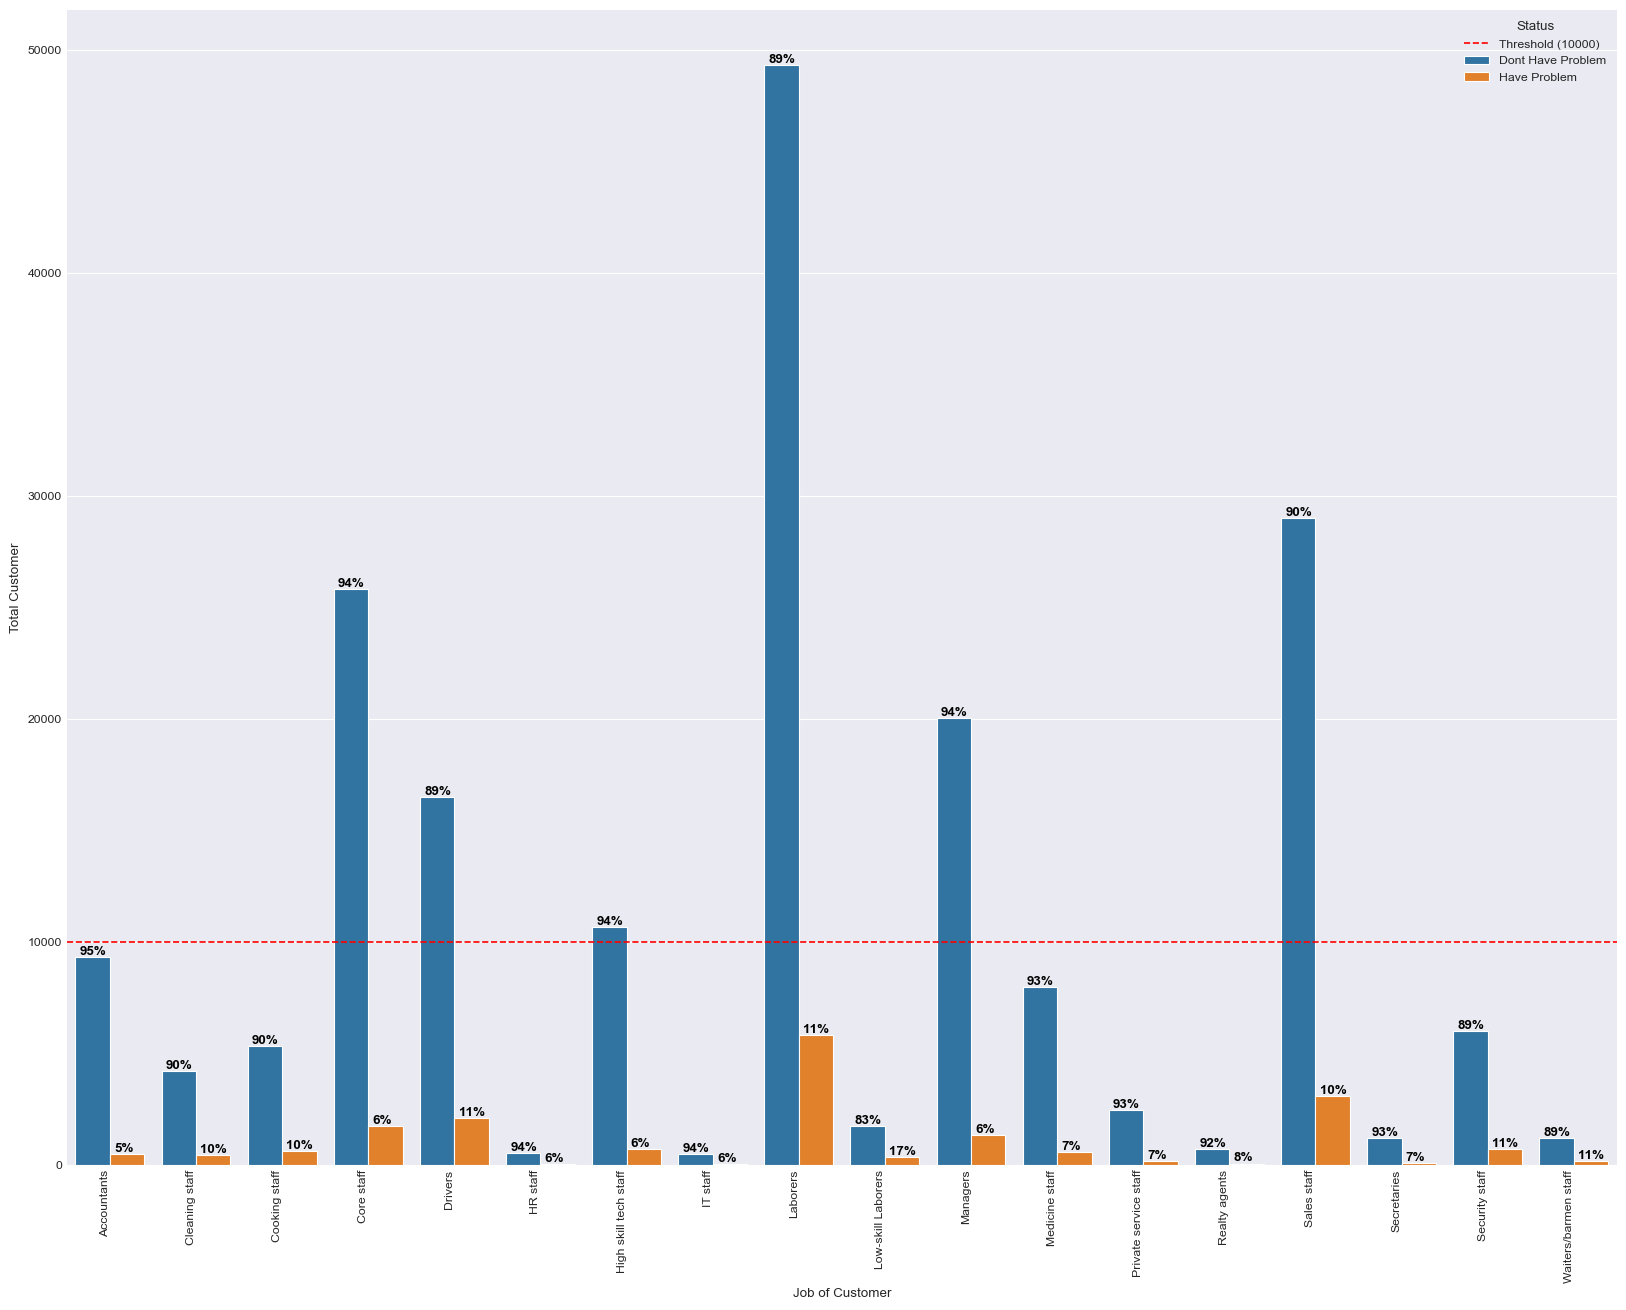

In [562]:
# ot_2 = ot[ot['OCCUPATION_TYPE'].isin(['HR staff', 'IT staff', 'Realty agents', 'Accountants'])]
ot_2 = ot[ot['OCCUPATION_TYPE'].isin(ot['OCCUPATION_TYPE'].unique())]
ot_2 = ot_2.reset_index()
ot_2.drop(columns = 'index', inplace=True)

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

ot_2['TARGET'] = ot_2['TARGET'].map(mapping_target)

plt.figure(figsize=(20, 15))  
ax = sns.barplot(x = 'OCCUPATION_TYPE', y= 'Customers', hue= 'TARGET', data = ot_2)

plt.xlabel('Job of Customer')
plt.ylabel('Total Customer')

threshold_value = 10000  # Adjust the threshold value as needed
plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold ({threshold_value})')

plt.legend(title = 'Status', bbox_to_anchor = (1,1))

for i, v in enumerate(ot_2['Customers']):
    percentage_formatted = '{:.0f}%'.format(ot_2['percentage'][i] * 100)
    if i%2 == 0:
        plt.text(i/2 - 0.35, v + 100, s= percentage_formatted, color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, v + 100, s= percentage_formatted, color='black', fontweight='bold')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show(ax)

## Age of the customer

Since there is no customer age column, we will create it using the DAYS_BIRTH column which contains data on the difference between today and the customer's birthday.

In [563]:
df['Age'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)

now we make a grup based on customer age following this rules :

1. Young Adult = 20 - 35
2. Adult = 35 - 50
3. Older > 50

In [564]:
age_cat = []
for i in df['Age']:
    if i < 36:
        age_cat.append('Young Adult')
    elif i < 51:
        age_cat.append('Adult')
    else:
        age_cat.append('Older')

df['Age_category'] = age_cat

In [565]:
g_age = df.groupby(['TARGET', 'Age_category'])['CODE_GENDER'].count().reset_index().sort_values('Age_category').reset_index()
g_age.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
g_age.drop(columns = 'index', inplace=True)

name_of_ot = list(g_age['Age_category'].unique())
percentage = []

for i in name_of_ot:
    data = g_age[g_age['Age_category'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

g_age['percentage'] = percentage

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

g_age['TARGET'] = g_age['TARGET'].map(mapping_target)
g_age

,TARGET,Age_category,Customers,percentage
0,Dont Have Problem,Adult,108678,0.92
1,Have Problem,Adult,9403,0.08
2,Dont Have Problem,Older,91718,0.94
3,Have Problem,Older,5469,0.06
4,Dont Have Problem,Young Adult,82290,0.89
5,Have Problem,Young Adult,9953,0.11


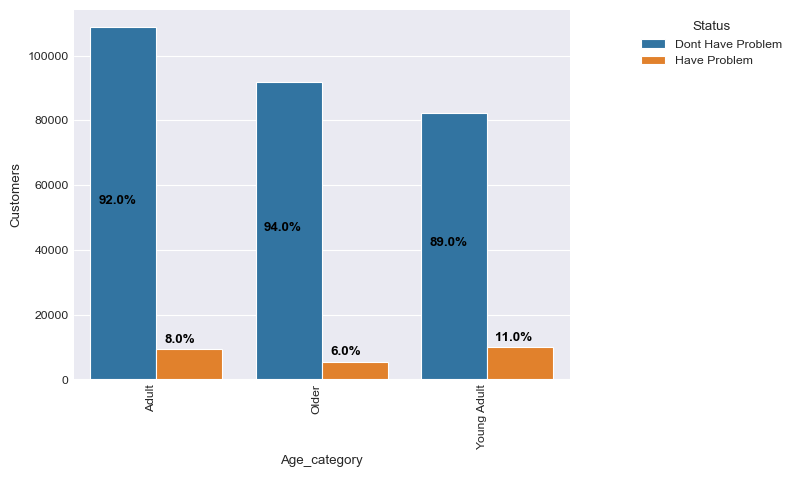

In [566]:
ax = sns.barplot(x = 'Age_category', y= 'Customers', hue= g_age.TARGET, data = g_age)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(g_age['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v/2, s= str(g_age['percentage'][i]* 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, v + 2000, s= str(g_age['percentage'][i] * 100) + '%', color='black', fontweight='bold')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show(ax)

From graphic above, we can see that Adult (35-50 years old) is the age category that has the largest loan applications with 92% of the loans being paid off without experiencing any problems, so we can target adults to have a loan in Home credit Indonesia.

In [567]:
df.drop(columns = 'Age_category', inplace=True)

## Income Type of consumer

In [568]:
itc = df.groupby(['TARGET', 'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(['NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE']).reset_index()
itc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
itc.drop(columns = 'index', inplace=True)

income_type   = list(itc['NAME_INCOME_TYPE'].unique())
percentage  = []

for i in income_type:
    data = itc[itc.NAME_INCOME_TYPE == i]
    contract_type = list(data['NAME_CONTRACT_TYPE'].unique())
    for x in contract_type:
        data2 = data[data.NAME_CONTRACT_TYPE == x]
        total = data2['Customers'].sum()
        for y,z in enumerate(data2['Customers']):
            pct = round(z / total, 2)
            percentage.append(pct)
            
itc['percentage'] = percentage
itc

,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,0,Businessman,Revolving loans,10,1.00
1,0,Commercial associate,Cash loans,58662,0.92
2,1,Commercial associate,Cash loans,4990,0.08
3,0,Commercial associate,Revolving loans,7595,0.95
4,1,Commercial associate,Revolving loans,370,0.05
5,1,Maternity leave,Cash loans,2,1.00
6,0,Maternity leave,Revolving loans,3,1.00
7,0,Pensioner,Cash loans,49151,0.95
8,1,Pensioner,Cash loans,2842,0.05
9,0,Pensioner,Revolving loans,3229,0.96


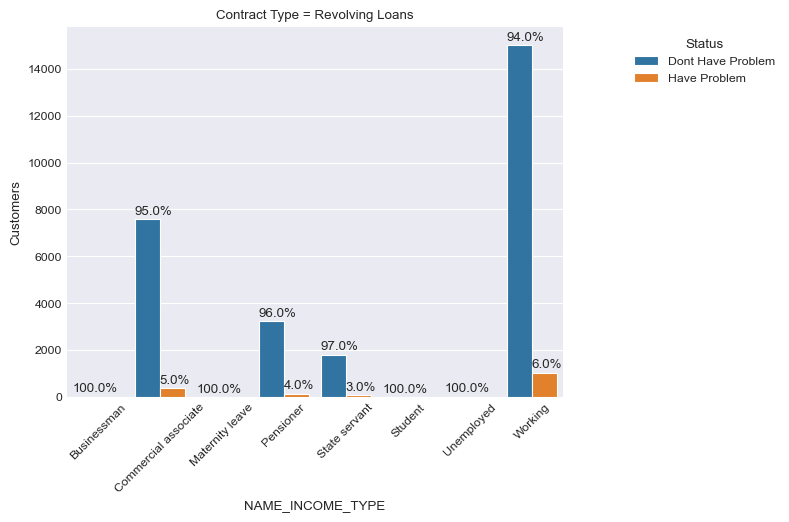

In [569]:
itc_rl = itc[itc['NAME_CONTRACT_TYPE'] == 'Revolving loans'].reset_index()

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

itc_rl['TARGET'] = itc_rl['TARGET'].map(mapping_target)

ax = sns.barplot(x = 'NAME_INCOME_TYPE', y= 'Customers', data = itc_rl, hue = 'TARGET')
plt.title('Contract Type = Revolving Loans')
plt.xticks(rotation=45)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

#for i, v in enumerate(itc_rl['Customers']):
 #   plt.text(i/2 - 0.2, v + 200, s= str(itc_rl['percentage'][i]* 100) + '%', color='black', fontweight='bold', fontsize = 8)
i = 0
itc_p = itc_rl.sort_values('TARGET').reset_index()
for p in ax.patches:
    widht, height = p.get_x(), p.get_height()
    if np.isnan(height) == True:
        continue
    else:
        plt.text(widht, height + 200, s = str(itc_p['percentage'][i]* 100) + '%' )
        i = i +1
        
plt.show()

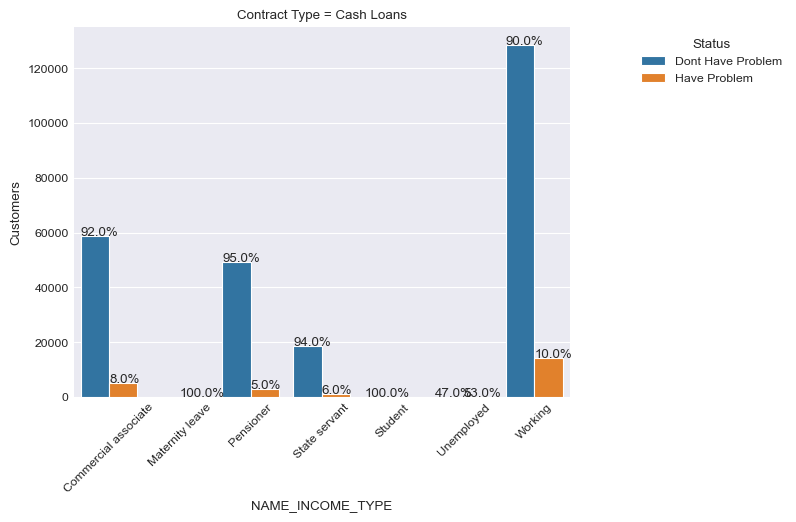

In [570]:
itc_cl = itc[itc['NAME_CONTRACT_TYPE'] == 'Cash loans'].reset_index()

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

itc_cl['TARGET'] = itc_cl['TARGET'].map(mapping_target)

ax = sns.barplot(x = 'NAME_INCOME_TYPE', y= 'Customers', data = itc_cl, hue = 'TARGET')
plt.title('Contract Type = Cash Loans')
plt.xticks(rotation=45)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

#for i, v in enumerate(itc_rl['Customers']):
 #   plt.text(i/2 - 0.2, v + 200, s= str(itc_rl['percentage'][i]* 100) + '%', color='black', fontweight='bold', fontsize = 8)
i = 0
itc_p2 = itc_cl.sort_values('TARGET').reset_index()
for p in ax.patches:
    widht, height = p.get_x(), p.get_height()
    if np.isnan(height) == True:
        continue
    else:
        plt.text(widht, height + 200, s = str(itc_p2['percentage'][i]* 100) + '%' )
        i = i +1
        
plt.show()

In [571]:
itc_cl

,index,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,1,Dont Have Problem,Commercial associate,Cash loans,58662,0.92
1,2,Have Problem,Commercial associate,Cash loans,4990,0.08
2,5,Have Problem,Maternity leave,Cash loans,2,1.00
3,7,Dont Have Problem,Pensioner,Cash loans,49151,0.95
4,8,Have Problem,Pensioner,Cash loans,2842,0.05
5,11,Dont Have Problem,State servant,Cash loans,18648,0.94
6,12,Have Problem,State servant,Cash loans,1188,0.06
7,15,Dont Have Problem,Student,Cash loans,15,1.00
8,17,Dont Have Problem,Unemployed,Cash loans,7,0.47
9,18,Have Problem,Unemployed,Cash loans,8,0.53


# Data Cleaning

### Detecting Data Duplication

In [572]:
print('The number of duplication is:', df_train.duplicated().sum())
# there is no duplication

The number of duplication is: 0


### Detecting Missing Values

In [573]:
# check for empty elements
print('Missing values status:', df_train.isnull().values.any())
nvc = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


In [574]:
# drop features that have large number of missing values (± 50%)
df_train.drop(df_train.iloc[:, 44:91], inplace=True, axis=1)
df_train.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [575]:
# after drop some features
print('Missing values status:', df_train.isnull().values.any())
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
5,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631
6,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
7,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631
8,NAME_TYPE_SUITE,1292,0.420148
9,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.332021


It can be seen that the distribution of numerical features that mentioned above is skewed, so the missing values in those features will be imputed with the median.

In [576]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df_train.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_train.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_train:
    if df_train[column].isnull().any():
        if(column in category_columns):
            df_train[column]=df_train[column].fillna(df_train[column].mode()[0])
        else:
            df_train[column]=df_train[column].fillna(df_train[column].median())

In [577]:
# after imputation
print('Missing values status:', df_train.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
5,NAME_CONTRACT_TYPE,0,0.0
6,CODE_GENDER,0,0.0
7,FLAG_OWN_CAR,0,0.0
8,FLAG_OWN_REALTY,0,0.0
9,CNT_CHILDREN,0,0.0


### Detecting Outliers

In [578]:
# dataset that only consist numerical features pt.1
int_features = df_train[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]

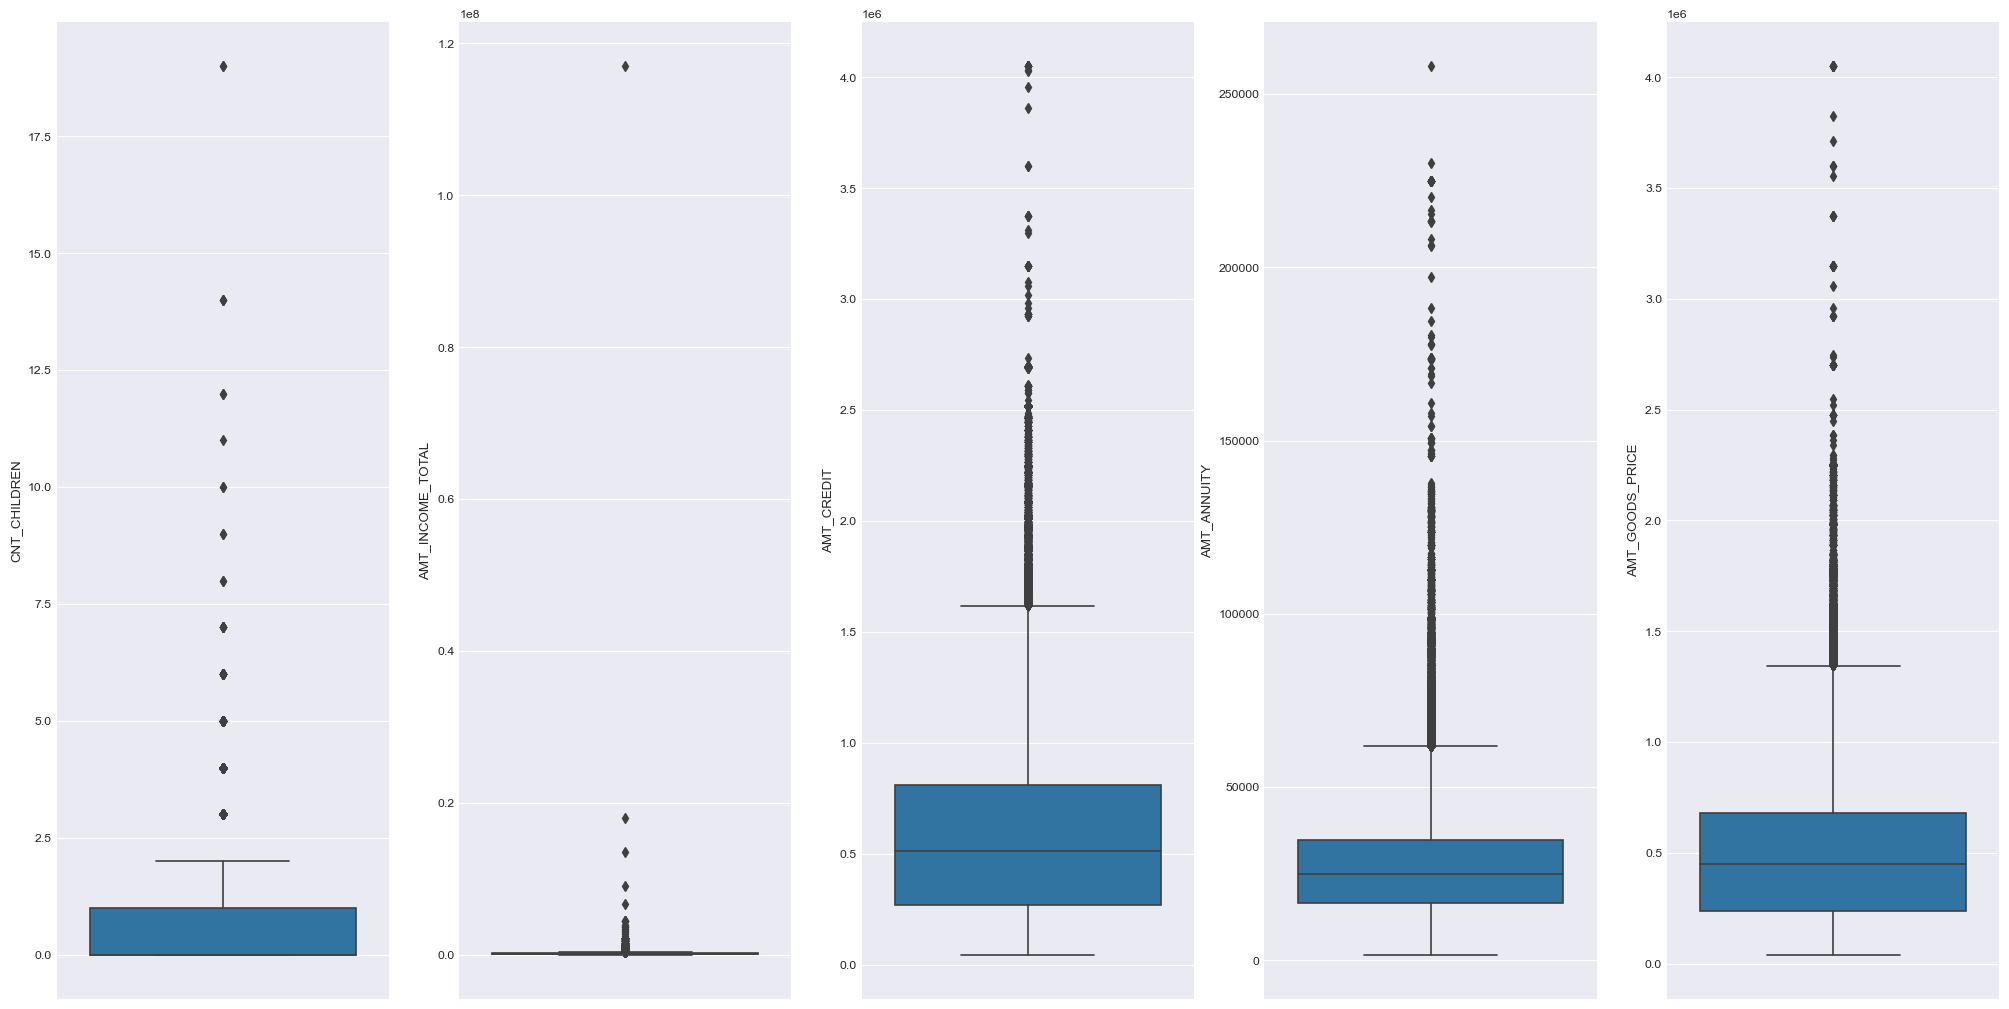

In [579]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [580]:
# dataset that only consist numerical features pt.2
int_features = df_train[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"]]

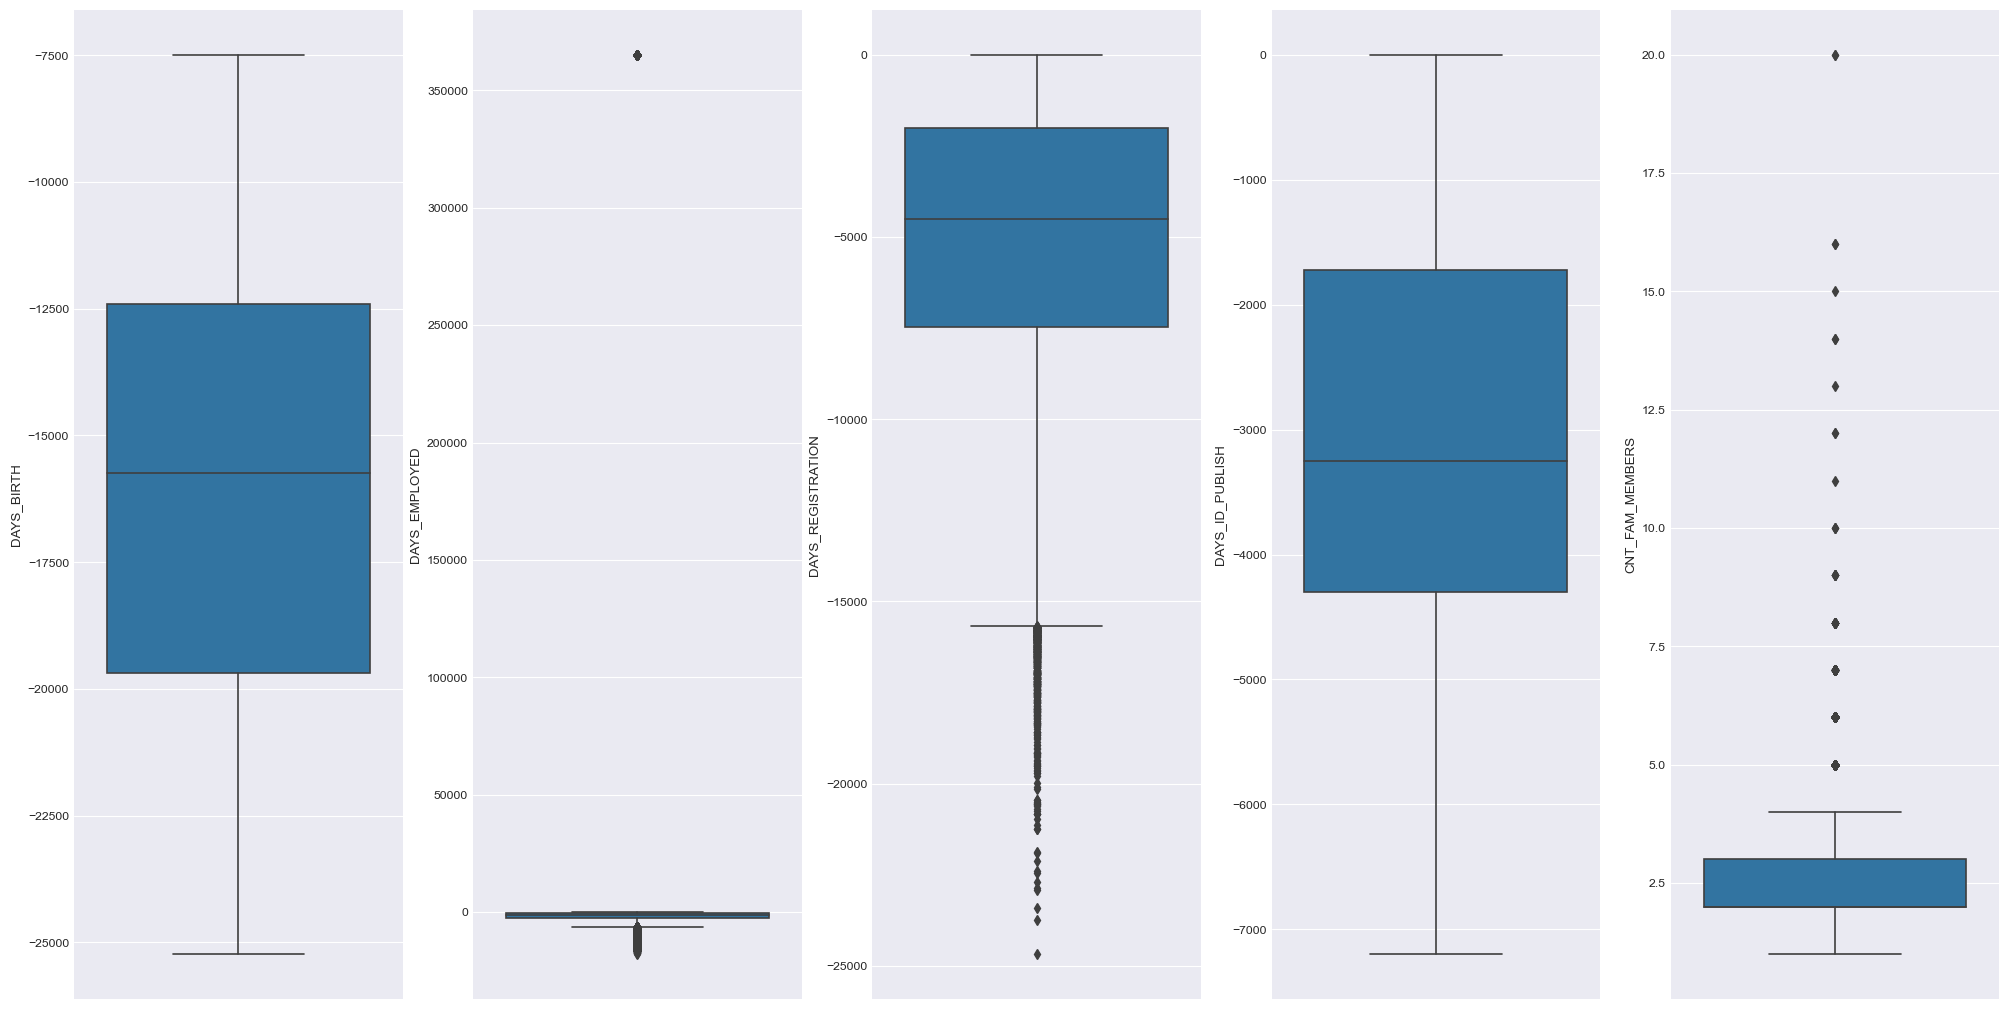

In [581]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [582]:
# dataset that only consist numerical features pt.3
int_features = df_train[["AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]]

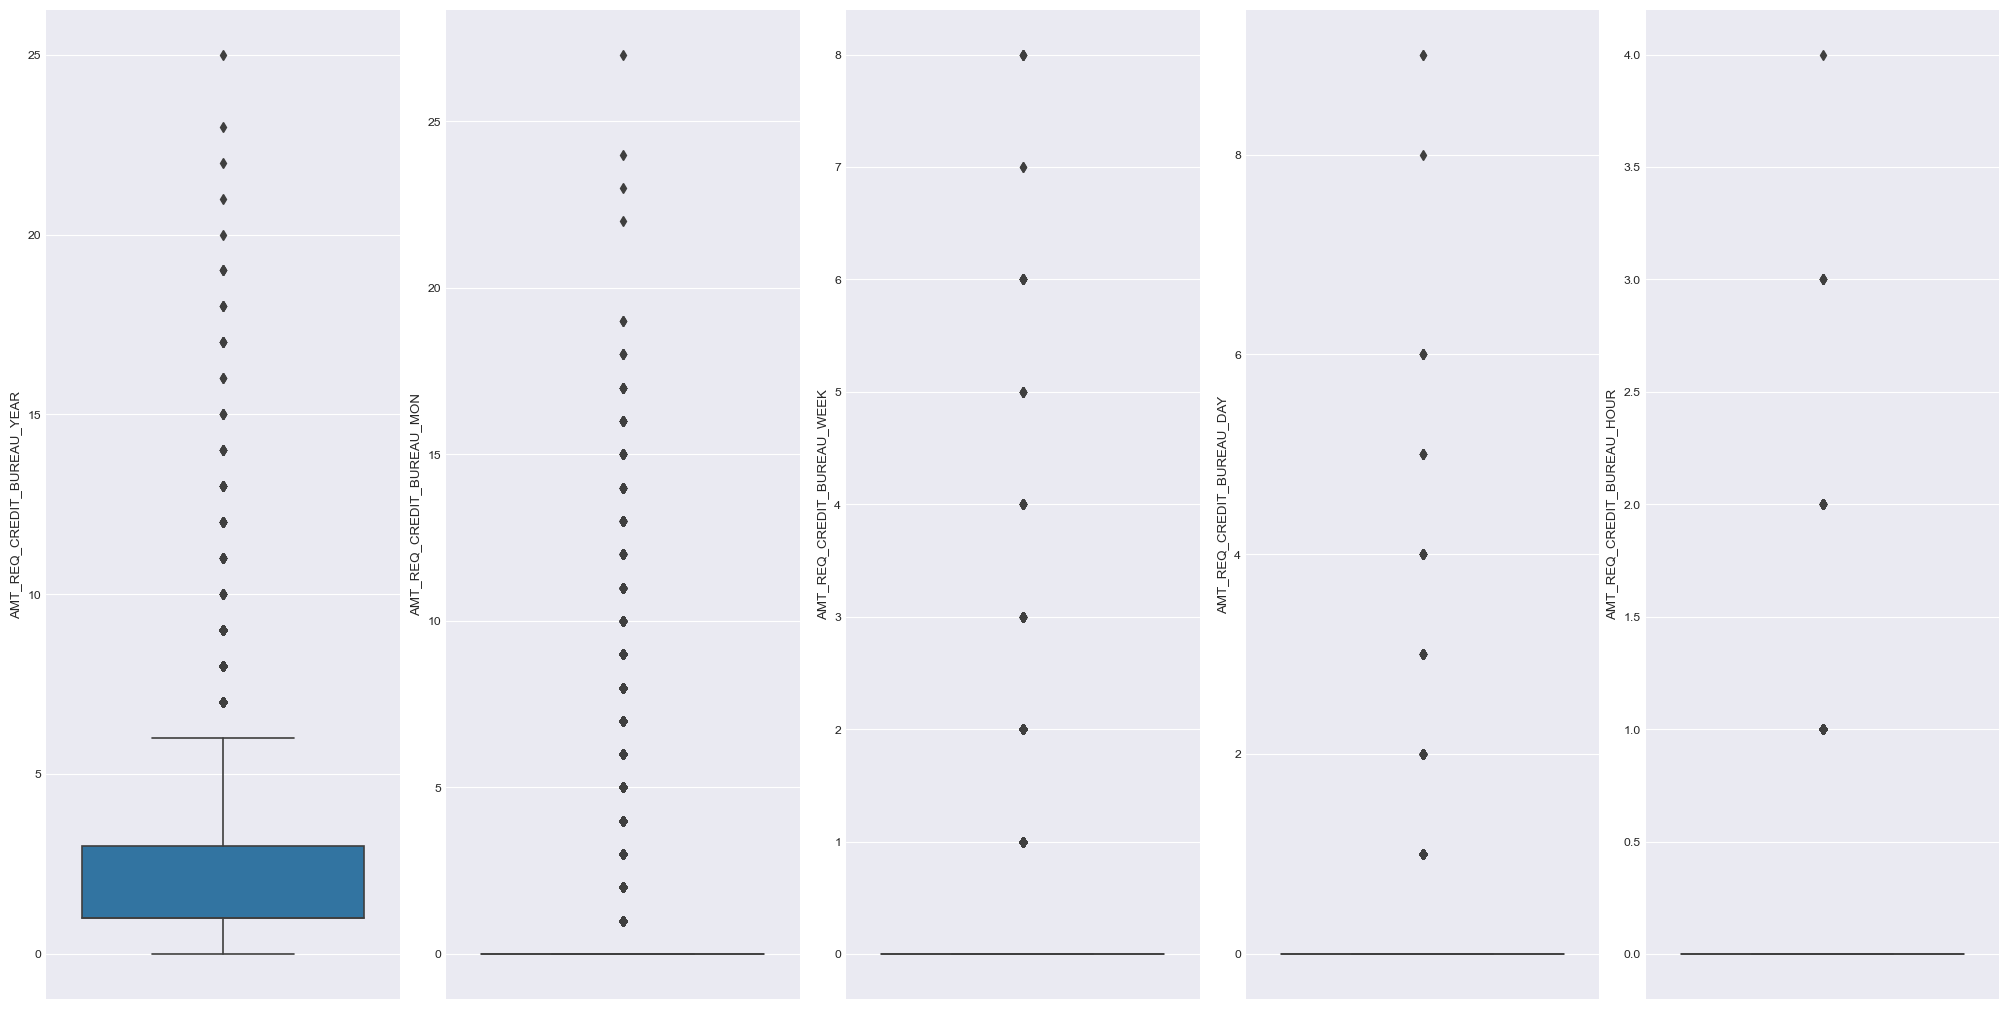

In [583]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [584]:
# dataset that only consist numerical features pt.4
int_features = df_train[["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE"]]

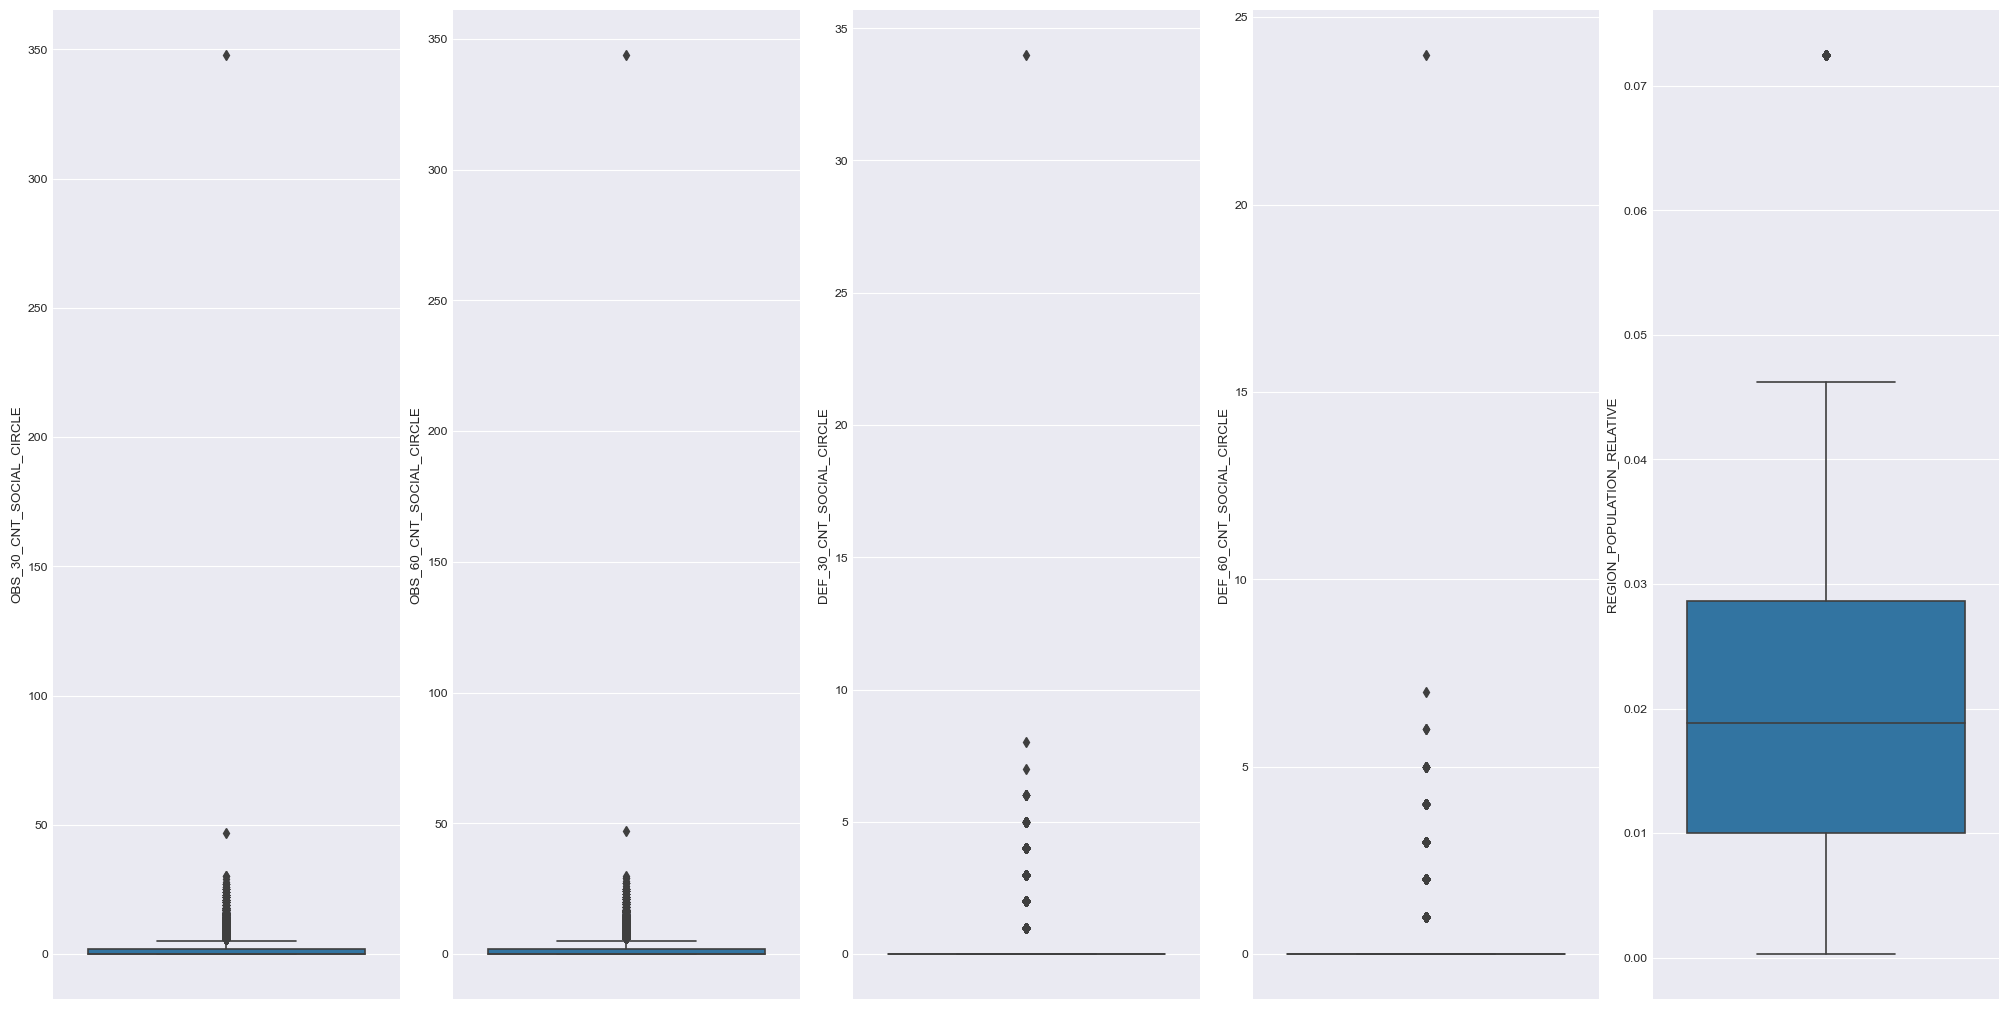

In [585]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [586]:
# dataset that only consist numerical features pt.5
int_features = df_train[["REGION_RATING_CLIENT", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "AMT_REQ_CREDIT_BUREAU_QRT"]]

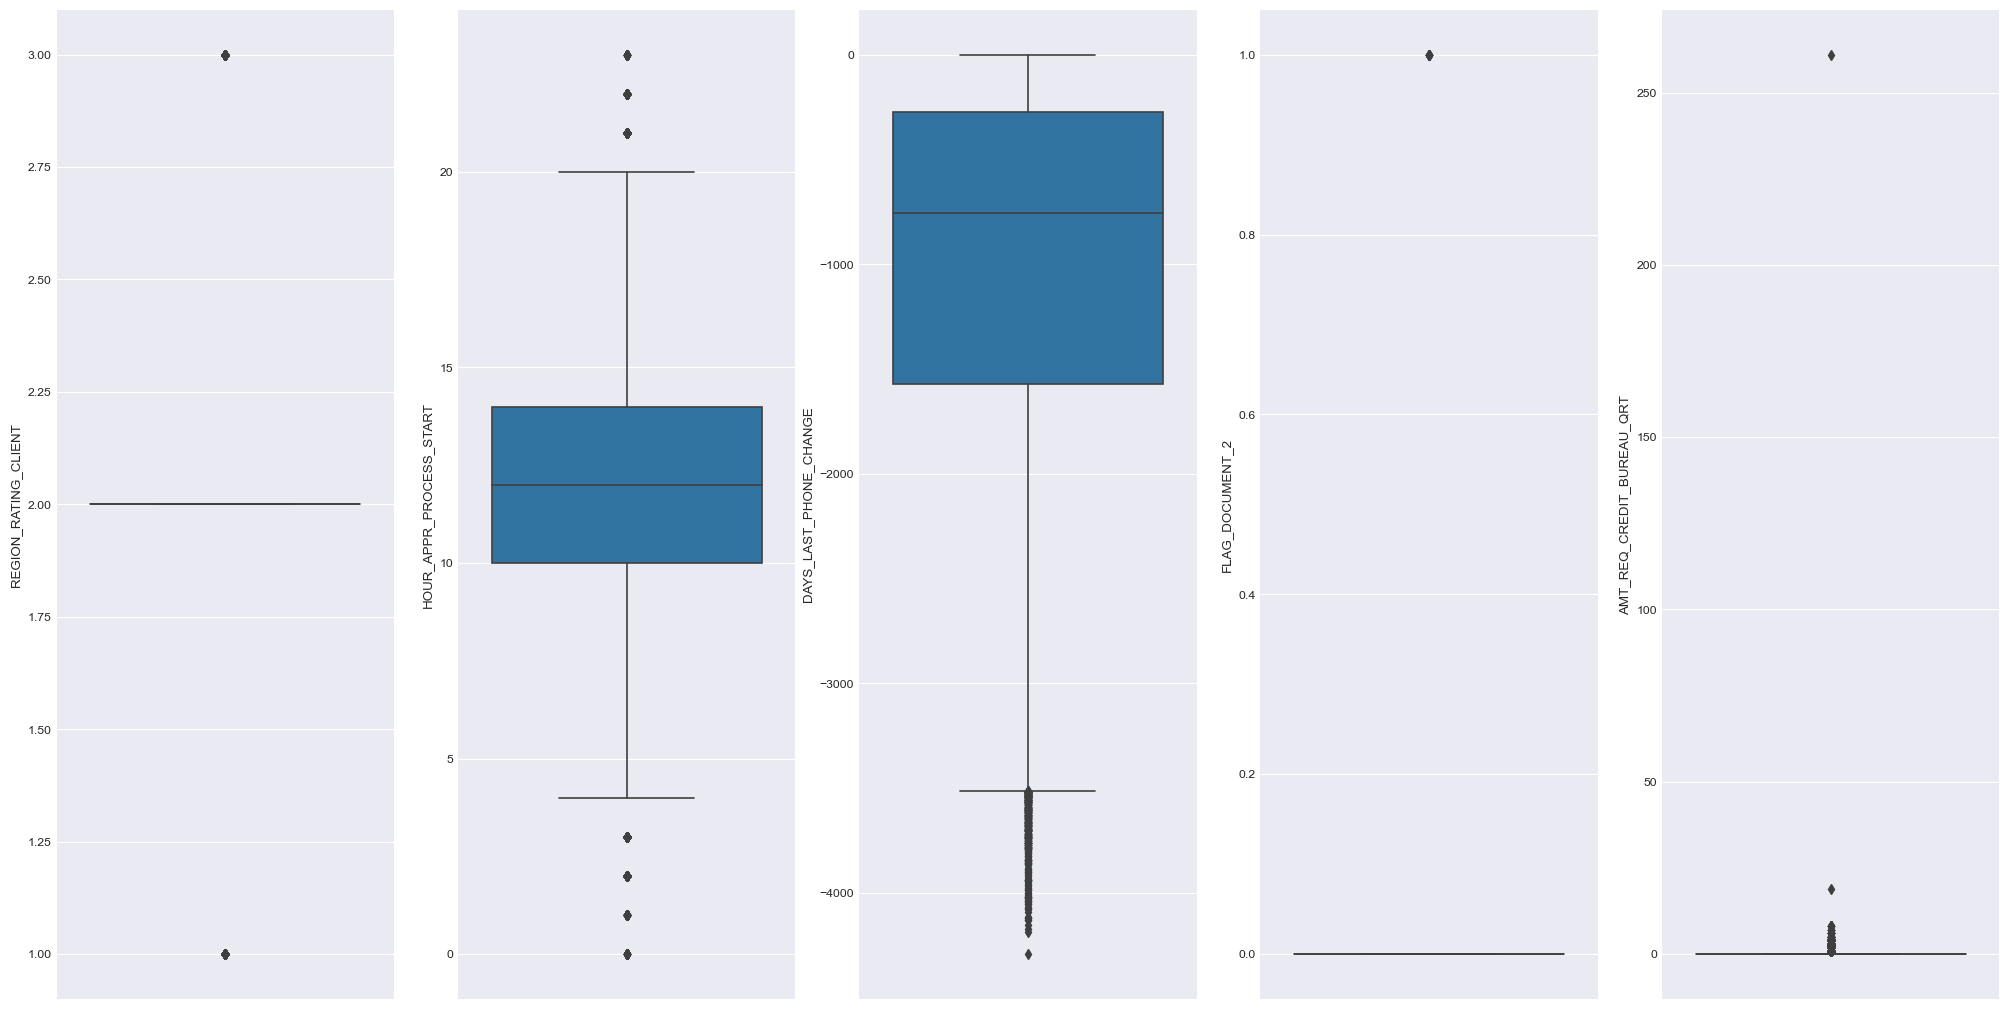

In [587]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Outliers on the numerical features mentioned above will not be removed because there may be insights that can be drawn from these outliers.

## Machine Learning Models

### Label Encoding

In [588]:
# label encoder for object features
df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [589]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

#### Drop Unnecessary Feature

In [590]:
df_train.drop(['SK_ID_CURR'], inplace=True, axis=1)

In [591]:
df_train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Convert Negative Values to Positive Values

The features that have negative values are `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`, `DAYS_REGISTRATION`, and `DAYS_LAST_PHONE_CHANGE`

In [592]:
df_train.iloc[:,16:20] = df_train.iloc[:,16:20].abs()
df_train.iloc[:,45] = df_train.iloc[:,45].abs()

#### Feature Selection

In [593]:
x = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']

In [594]:
# feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
17,DAYS_REGISTRATION,1.348566e+06
44,DAYS_LAST_PHONE_CHANGE,6.656876e+05
18,DAYS_ID_PUBLISH,6.195946e+05
7,AMT_ANNUITY,3.913092e+05
37,ORGANIZATION_TYPE,4.138607e+03


It can be seen which features correlate well with payment difficulties.

1. **Best features**: `DAYS_EMPLOYED`, `AMT_GOODS_PRICE`, and `AMT_CREDIT`

2. **Worst features**: `FLAG_MOBIL`, `FLAG_CONT_MOBILE`, and `AMT_REQ_CREDIT_BUREAU_HOUR`

### Handling Data Imbalance

In [595]:
# create two different dataframe of majority and minority class 
df_majority = df_train[(df_train['TARGET']==0)] 
df_minority = df_train[(df_train['TARGET']==1)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 282686, # to match majority class
                                 random_state=42)  # reproducible results

# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

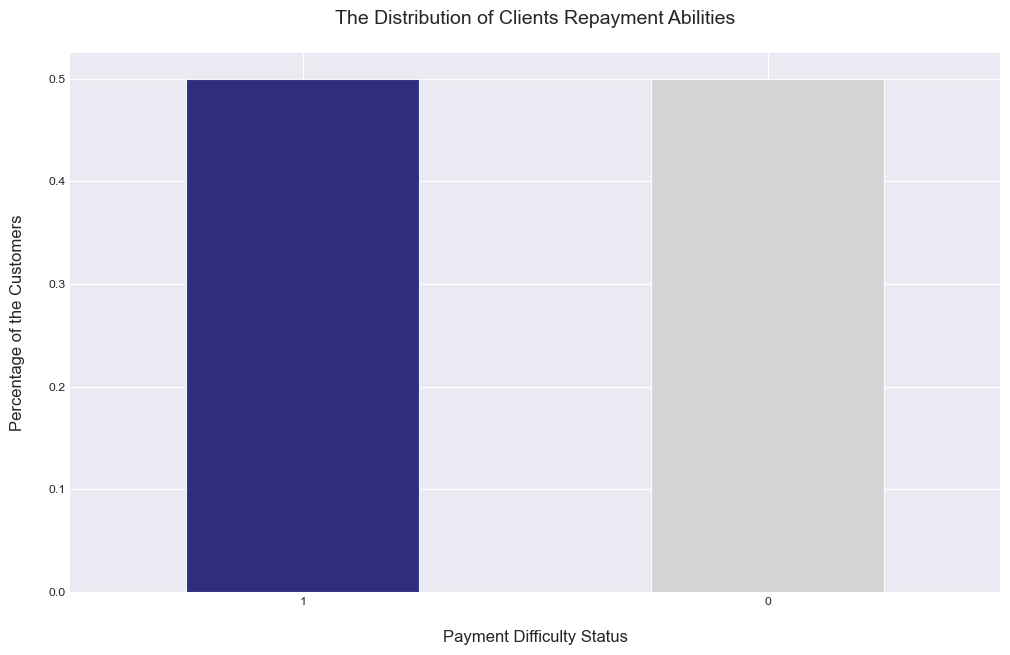

In [596]:
fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['midnightblue','lightgrey'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('\nPayment Difficulty Status', fontsize=12)
plt.show()

It can be seen that the data is balanced, so the analysis can be continued.

### **Data Splitting**

In [597]:
# define x and y features (top 20 features)
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [598]:
# splitting tha data
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(452297, 20) (113075, 20)


In [599]:
# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Building

Here are some algorithms that will be tested to determine the best model:
1. Logistic Regression
2. Gaussian Naive Bayes
3. Decision Tree
4. Random Forest
5. K-Nearest Neighbor
6. Neural Network

#### 1. Logistic Regression

In [600]:
# train the model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


In [601]:
# predict data train
y_train_pred_log = log_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



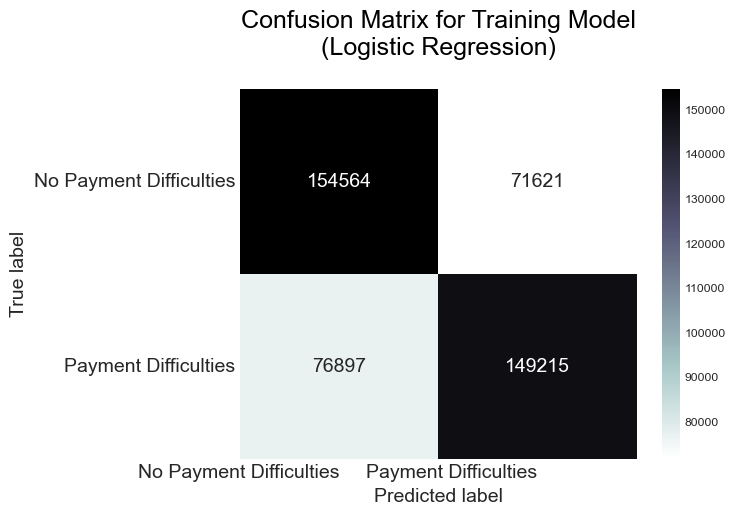

In [602]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [603]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



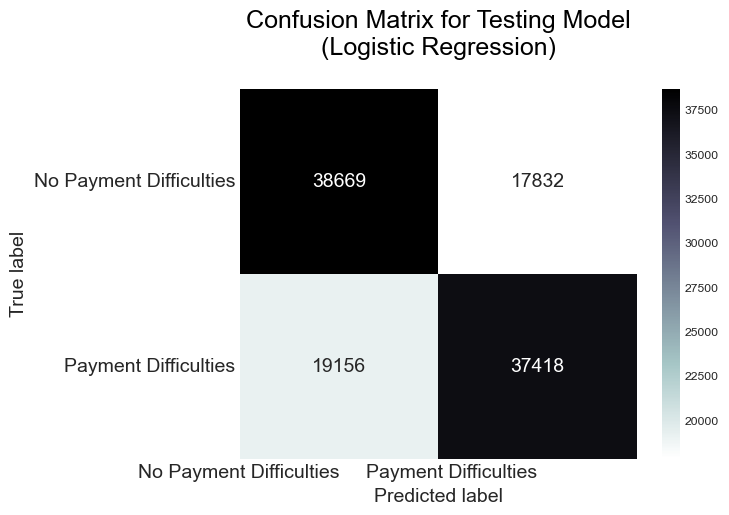

In [604]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [605]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 67.16
Test Accuracy: % 67.29


It can be seen that:
- Logistic regression model gives 67.16% correct results.
- There is 0.13% error margin.

In [606]:
# ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.6729


#### 2. Gaussian Naive Bayes

In [607]:
# train the model
gnb_model = GaussianNB().fit(X_train, y_train)
print(gnb_model)

GaussianNB()


In [608]:
# predict data train
y_train_pred_gnb = gnb_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Gaussian Naive Bayes):')
print(classification_report(y_train, y_train_pred_gnb))

Classification Report Training Model (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.57      0.84      0.68    226185
           1       0.69      0.37      0.48    226112

    accuracy                           0.60    452297
   macro avg       0.63      0.60      0.58    452297
weighted avg       0.63      0.60      0.58    452297



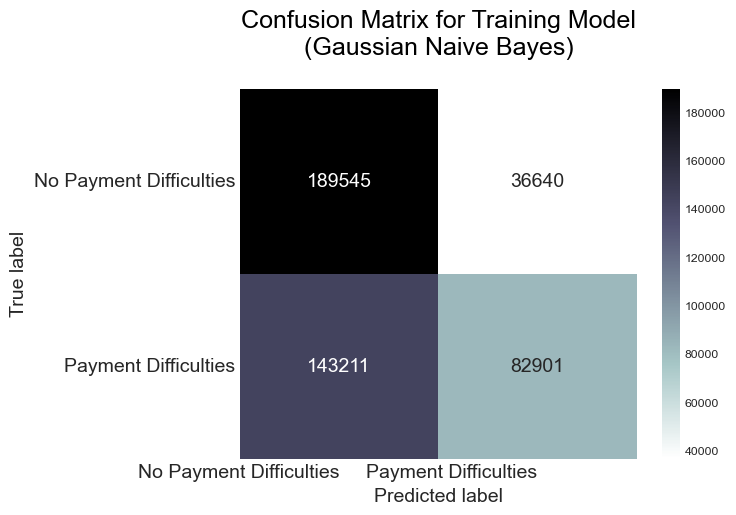

In [609]:
# form confusion matrix as a dataFrame
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_train, y_train_pred_gnb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gaussian Naive Bayes)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [610]:
# predict data test
y_test_pred_gnb = gnb_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Gaussian Naive Bayes):')
print(classification_report(y_test, y_test_pred_gnb))

Classification Report Testing Model (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.57      0.84      0.68     56501
           1       0.70      0.36      0.48     56574

    accuracy                           0.60    113075
   macro avg       0.63      0.60      0.58    113075
weighted avg       0.64      0.60      0.58    113075



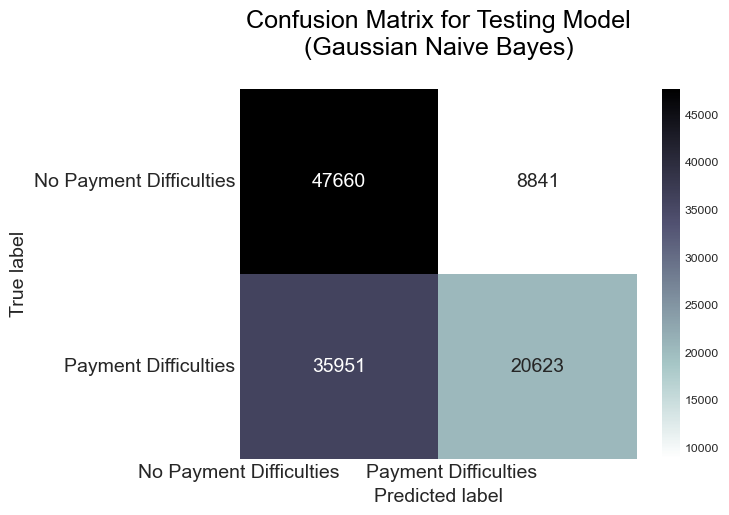

In [611]:
# form confusion matrix as a dataFrame
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_test, y_test_pred_gnb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gaussian Naive Bayes)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [612]:
acc_nb_train=round(gnb_model.score(X_train,y_train)*100,2)
acc_nb_test=round(gnb_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nb_train))
print("Test Accuracy: % {}".format(acc_nb_test))

Training Accuracy: % 60.24
Test Accuracy: % 60.39


It can be seen that:
- Gaussian naive bayes model gives 60.24% correct results.
- There is 0.15% error margin.

In [613]:
# ROC scores
roc_auc_gnb = round(roc_auc_score(y_test, y_test_pred_gnb),4)
print('ROC AUC:', roc_auc_gnb)

ROC AUC: 0.604


#### 3. Decision Tree

In [614]:
# train the model
dt_model = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_model)

DecisionTreeClassifier()


In [615]:
# predict data train
y_train_pred_dt = dt_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



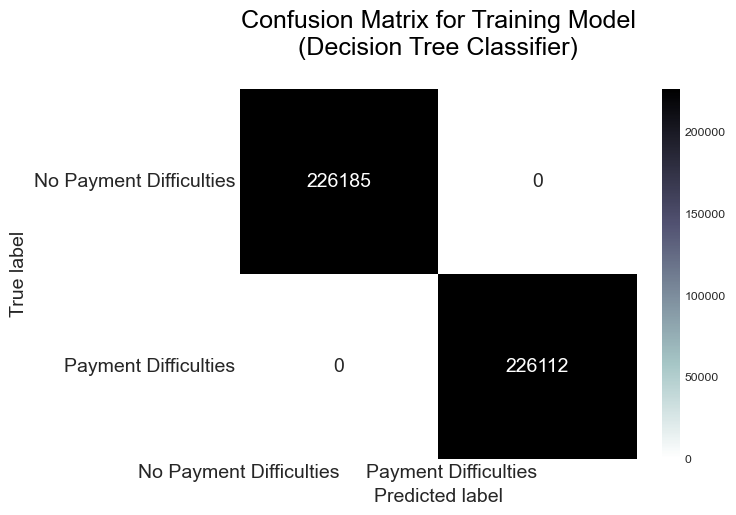

In [616]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [617]:
# predict data test
y_test_pred_dt = dt_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Decision Tree Classifier):')
print(classification_report(y_test, y_test_pred_dt))

Classification Report Testing Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56501
           1       0.90      0.86      0.88     56574

    accuracy                           0.88    113075
   macro avg       0.88      0.88      0.88    113075
weighted avg       0.88      0.88      0.88    113075



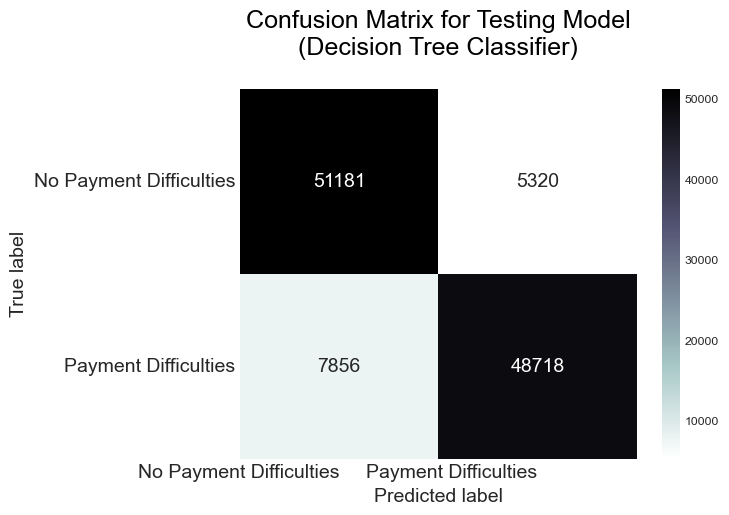

In [618]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [619]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 88.35


It can be seen that:
- Decision tree model gives 100% correct results.
- There is 11.74% error margin. This is not good for this data.

In [620]:
# ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8835


#### 4. Random Forest

In [621]:
# train the model
rf_model = RandomForestClassifier().fit(X_train, y_train)
print(rf_model)

RandomForestClassifier()


In [622]:
# predict data train
y_train_pred_dt = rf_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



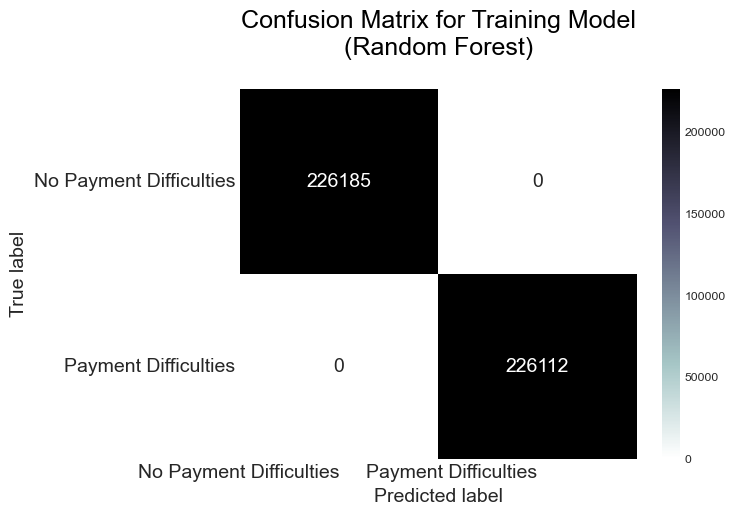

In [623]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [624]:
# predict data test
y_test_pred_rf = rf_model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report

# print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred_rf))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56501
           1       0.99      1.00      1.00     56574

    accuracy                           1.00    113075
   macro avg       1.00      1.00      1.00    113075
weighted avg       1.00      1.00      1.00    113075



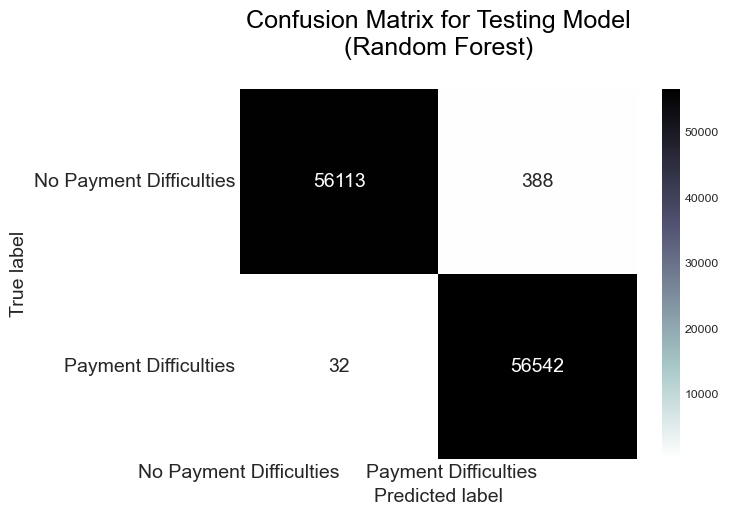

In [625]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [626]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Test Accuracy: % 99.63


It can be seen that:
- Random forest model gives 100% correct results.
- There is 0.35% error margin.

In [627]:
# ROC scores
roc_auc_rf = round(roc_auc_score(y_test, y_test_pred_rf),4)
print('ROC AUC:', roc_auc_rf)

ROC AUC: 0.9963


C:\Users\lowed001\AppData\Local\Temp\ipykernel_9220\2987368929.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


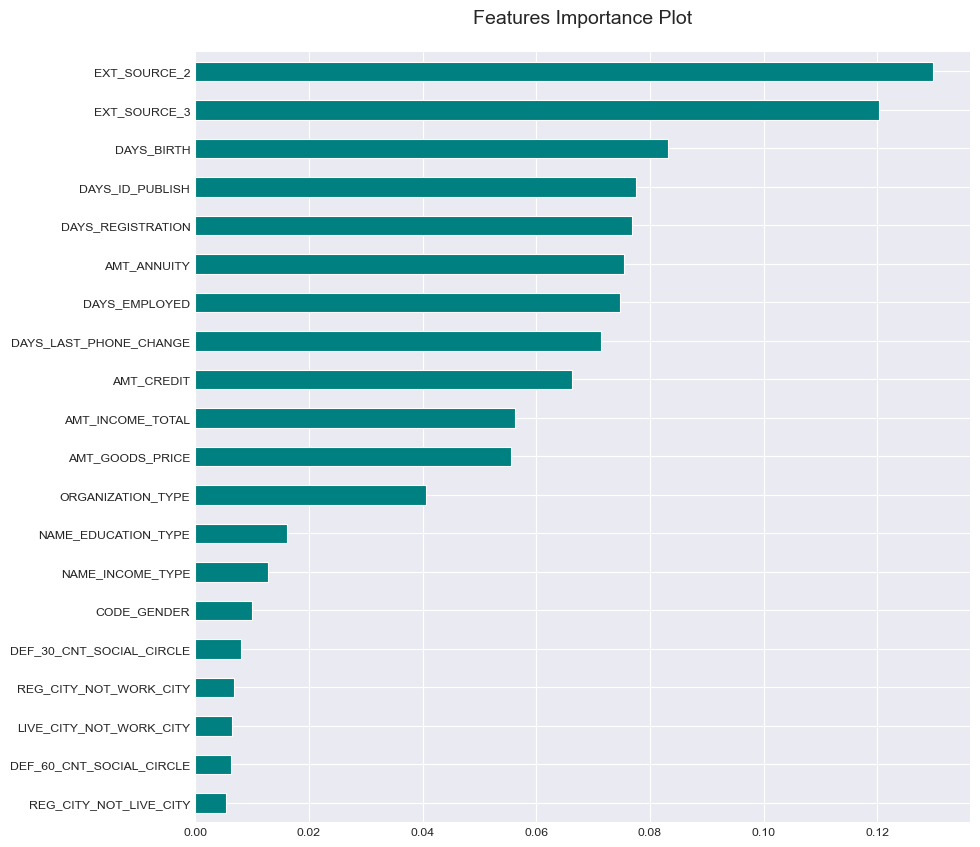

In [628]:
# important features
importances_rf = pd.Series(rf_model.feature_importances_, index=x_balanced.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

The plot above confirms that the 5 most important features are `EXT_SOURCE_2`, `EXT_SOURCE_3`, `DAYS_BIRTH`, `DAYS_ID_PUBLISH`, and `DAYS_REGISTRATION`

#### 5. K-Nearest Neighbors

In [629]:
# train the model
knn_model = KNeighborsClassifier().fit(X_train,y_train)
print(knn_model)

KNeighborsClassifier()


In [630]:
# predit data train
y_train_pred_knn = knn_model.predict(X_train)

# print classification report
print('Classification Report Training Model (K-Nearest Neighbors):')
print(classification_report(y_train, y_train_pred_knn))

Classification Report Training Model (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    226185
           1       0.86      1.00      0.92    226112

    accuracy                           0.92    452297
   macro avg       0.93      0.92      0.92    452297
weighted avg       0.93      0.92      0.92    452297



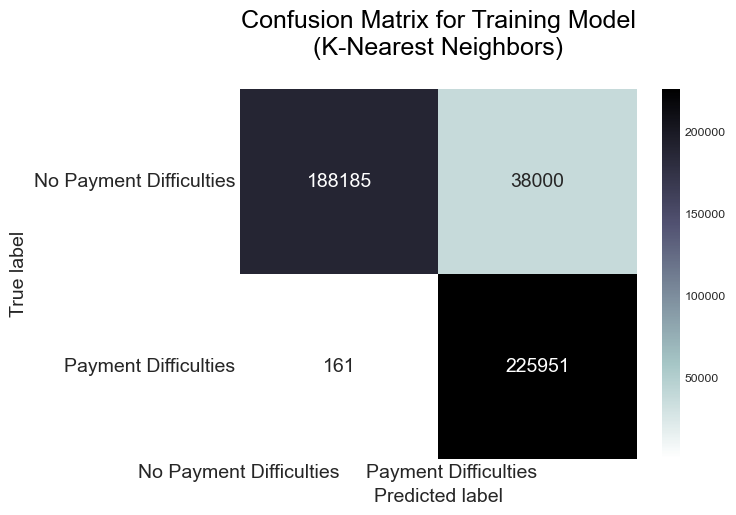

In [631]:
# form confusion matrix as a dataFrame
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_train, y_train_pred_knn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(K-Nearest Neighbors)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [632]:
# predit data test
y_test_pred_knn = knn_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (K-Nearest Neighbors):')
print(classification_report(y_test, y_test_pred_knn))

Classification Report Testing Model (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     56501
           1       0.81      1.00      0.89     56574

    accuracy                           0.88    113075
   macro avg       0.90      0.88      0.88    113075
weighted avg       0.90      0.88      0.88    113075



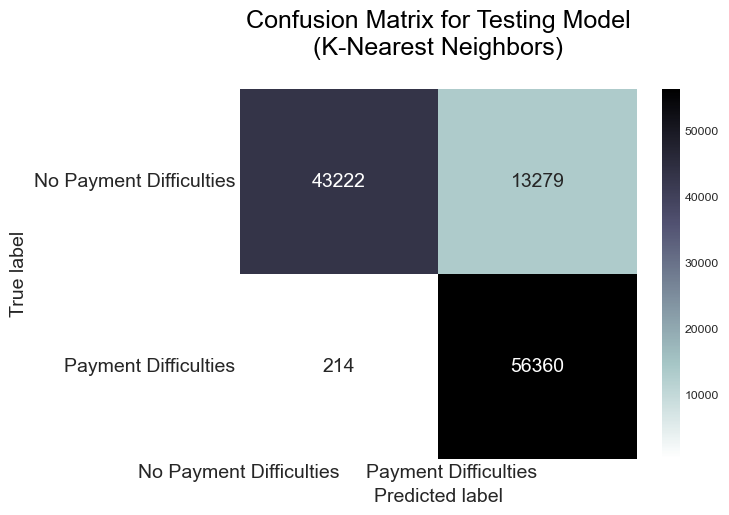

In [633]:
# form confusion matrix as a dataFrame
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_test, y_test_pred_knn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(K-Nearest Neighbors)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [634]:
acc_knn_train=round(knn_model.score(X_train,y_train)*100,2)
acc_knn_test=round(knn_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_knn_train))
print("Test Accuracy: % {}".format(acc_knn_test))

Training Accuracy: % 91.56
Test Accuracy: % 88.07


It can be seen that:
- K-nearest neighbor model gives 91.56% correct results.
- There is 3.79% error margin.

In [635]:
# ROC scores
roc_auc_knn = round(roc_auc_score(y_test, y_test_pred_knn),4)
print('ROC AUC:', roc_auc_knn)

ROC AUC: 0.8806


#### 6. Neural Network

In [636]:
# train the model
nn_model = MLPClassifier().fit(X_train, y_train)

In [637]:
# predit data train
y_train_pred_nn = nn_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Neural Network):')
print(classification_report(y_train, y_train_pred_nn))

Classification Report Training Model (Neural Network):
              precision    recall  f1-score   support

           0       0.70      0.69      0.70    226185
           1       0.70      0.71      0.70    226112

    accuracy                           0.70    452297
   macro avg       0.70      0.70      0.70    452297
weighted avg       0.70      0.70      0.70    452297



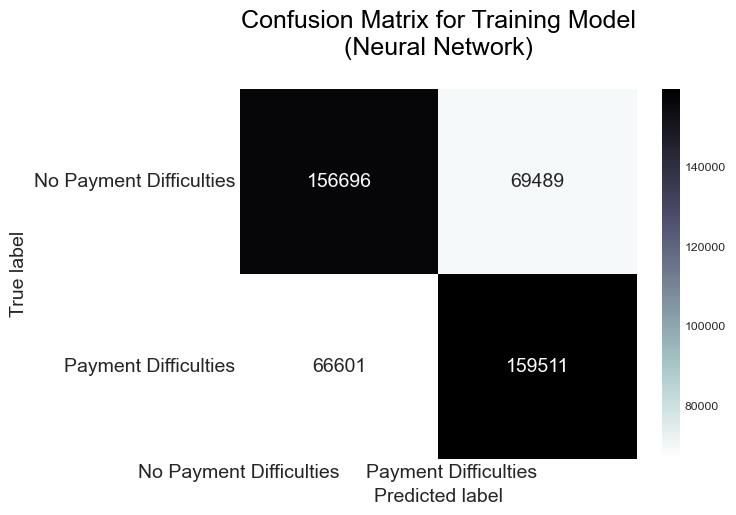

In [638]:
# form confusion matrix as a dataFrame
confusion_matrix_nn = pd.DataFrame((confusion_matrix(y_train, y_train_pred_nn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Neural Network)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [639]:
# predit data test
y_test_pred_nn = nn_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Neural Network):')
print(classification_report(y_test, y_test_pred_nn))

Classification Report Testing Model (Neural Network):


              precision    recall  f1-score   support

           0       0.70      0.69      0.69     56501
           1       0.69      0.70      0.70     56574

    accuracy                           0.69    113075
   macro avg       0.69      0.69      0.69    113075
weighted avg       0.69      0.69      0.69    113075



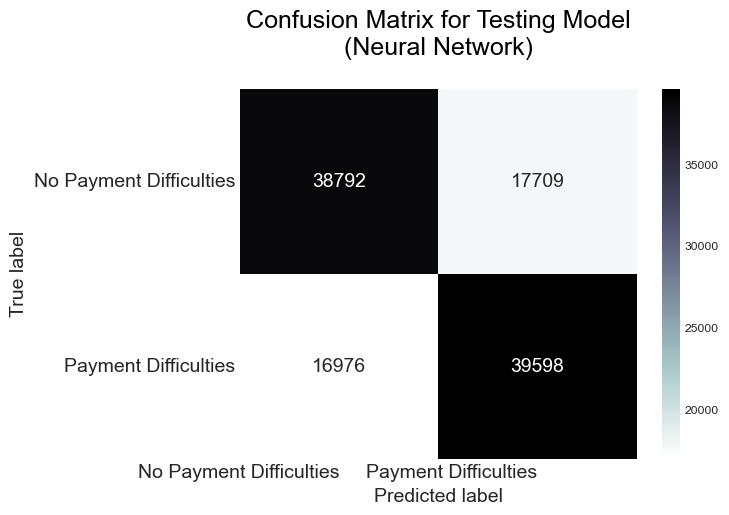

In [640]:
# form confusion matrix as a dataFrame
confusion_matrix_nn = pd.DataFrame((confusion_matrix(y_test, y_test_pred_nn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Neural Network)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [641]:
acc_nn_train=round(nn_model.score(X_train,y_train)*100,2)
acc_nn_test=round(nn_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nn_train))
print("Test Accuracy: % {}".format(acc_nn_test))

Training Accuracy: % 69.91
Test Accuracy: % 69.33


It can be seen that:
- Neural network model gives 70.01% correct results.
- There is 0.53% error margin.

In [642]:
# ROC scores
roc_auc_nn = round(roc_auc_score(y_test, y_test_pred_nn),4)
print('ROC AUC:', roc_auc_nn)

ROC AUC: 0.6933


### Model Selection

In [643]:
results = pd.DataFrame([["Logistic Regression", 0.6716, 0.6729, 0.6729],["Gaussian Naive Bayes", 0.6024, 0.6039, 0.604],
                       ["Decision Tree", 1, 0.8826, 0.8826],["Random Forest", 1, 0.9965, 0.9965],
                       ["K-Nearest Neighbor", 0.9156, 0.8807, 0.8806], ["Neural Network", 0.7001, 0.6948, 0.6948]],
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

,Models,Training Accuracy Score,Testing Accuracy Score,ROC Score
3,Random Forest,1.000000,0.996500,0.996500
2,Decision Tree,1.000000,0.882600,0.882600
4,K-Nearest Neighbor,0.915600,0.880700,0.880600
5,Neural Network,0.700100,0.694800,0.694800
0,Logistic Regression,0.671600,0.672900,0.672900
1,Gaussian Naive Bayes,0.602400,0.603900,0.604000


The prediction accuracy of the train and test data in **Random Forest** model has a value that is not much different, it can be said that the model is very good, which is there is **no underfitting or overfitting**. So the Random Forest model was chosen as the **best model to predict client’s repayment abilities**.

## Prediction

### Import Dataset

In [644]:
# data application (test)
df_test = pd.read_csv("application_test.csv", sep=',')
print('This dataset has %d rows dan %d columns.\n' % df_test.shape)
df_test.head()

This dataset has 48744 rows dan 121 columns.



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

There are total 48,744 rows which contains the information of loans and there are 121 features (without target feature).

### Data Preprocessing

#### Detecting Duplication

In [645]:
print('The number of duplication is:', df_test.duplicated().sum())
# there is no duplication

The number of duplication is: 0


#### Detecting Missing Values

In [646]:
# check for empty elements
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_AVG,33495,68.716150
1,COMMONAREA_MODE,33495,68.716150
2,COMMONAREA_MEDI,33495,68.716150
3,NONLIVINGAPARTMENTS_AVG,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
5,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
6,FONDKAPREMONT_MODE,32797,67.284179
7,LIVINGAPARTMENTS_AVG,32780,67.249302
8,LIVINGAPARTMENTS_MODE,32780,67.249302
9,LIVINGAPARTMENTS_MEDI,32780,67.249302


In [647]:
# drop features that have large number of missing values (± 50%)
df_test.drop(df_test.iloc[:, 43:90], inplace=True, axis=1)
df_test.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [648]:
# after drop some features
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,15605,32.014197
1,EXT_SOURCE_3,8668,17.782701
2,AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.409732
3,AMT_REQ_CREDIT_BUREAU_QRT,6049,12.409732
4,AMT_REQ_CREDIT_BUREAU_MON,6049,12.409732
5,AMT_REQ_CREDIT_BUREAU_WEEK,6049,12.409732
6,AMT_REQ_CREDIT_BUREAU_DAY,6049,12.409732
7,AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.409732
8,NAME_TYPE_SUITE,911,1.868948
9,OBS_30_CNT_SOCIAL_CIRCLE,29,0.059495


In [649]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = df_test.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_test:
    if df_test[column].isnull().any():
        if(column in category_columns):
            df_test[column]=df_test[column].fillna(df_test[column].mode()[0])
        else:
            df_test[column]=df_test[column].fillna(df_test[column].median())

In [650]:
# after imputation
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,NAME_CONTRACT_TYPE,0,0.0
2,FLAG_DOCUMENT_8,0,0.0
3,FLAG_DOCUMENT_7,0,0.0
4,FLAG_DOCUMENT_6,0,0.0
5,FLAG_DOCUMENT_5,0,0.0
6,FLAG_DOCUMENT_4,0,0.0
7,FLAG_DOCUMENT_3,0,0.0
8,FLAG_DOCUMENT_2,0,0.0
9,DAYS_LAST_PHONE_CHANGE,0,0.0


#### Label Encoding

In [651]:
# label encoder for object features
df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [652]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,6,6,1,1,1,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,8,2.0,2,2,5,18,0,0,0,0,0,0,28,0.789654,0.159520,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,6,6,4,1,1,0.035792,-18064,-4469,-9118.0,-1623,1,1,0,1,0,0,9,2.0,2,2,0,9,0,0,0,0,0,0,42,0.291656,0.432962,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,6,6,1,1,1,0.019101,-20038,-4458,-2175.0,-3503,1,1,0,1,0,0,4,2.0,2,2,1,14,0,0,0,0,0,0,54,0.699787,0.610991,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,6,6,4,1,1,0.026392,-13976,-1866,-2000.0,-4208,1,1,0,1,1,0,14,4.0,2,2,6,11,0,0,0,0,0,0,5,0.509677,0.612704,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,6,6,4,1,1,0.010032,-13040,-2191,-4000.0,-4262,1,1,1,1,0,0,8,3.0,2,2,0,5,0,0,0,0,1,1,5,0.425687,0.519097,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


#### Convert Negative Values to Positive Values

The features that have negative values are `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`, and `DAYS_REGISTRATION`, `DAYS_LAST_PHONE_CHANGE`

In [653]:
df_test.iloc[:,16:20] = df_test.iloc[:,16:20].abs()
df_test.iloc[:,45] = df_test.iloc[:,45].abs()

### Prediction

Predict client's repayment abilities on application data test with best machine learning model obtained before, i.e **Random Forest**.

In [654]:
pred_test = df_test[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_test.head()

,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,CODE_GENDER,EXT_SOURCE_2,REG_CITY_NOT_LIVE_CITY,NAME_EDUCATION_TYPE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_CITY_NOT_WORK_CITY
0,2329,450000.0,568800.0,19241,135000.0,5170.0,1740.0,812,20560.5,28,6,0,0,0.789654,0,1,0.0,0.159520,0.0,0
1,4469,180000.0,222768.0,18064,99000.0,9118.0,0.0,1623,17370.0,42,6,0,1,0.291656,0,4,0.0,0.432962,0.0,0
2,4458,630000.0,663264.0,20038,202500.0,2175.0,856.0,3503,69777.0,54,6,0,1,0.699787,0,1,0.0,0.610991,0.0,0
3,1866,1575000.0,1575000.0,13976,315000.0,2000.0,1805.0,4208,49018.5,5,6,0,0,0.509677,0,4,0.0,0.612704,0.0,0
4,2191,625500.0,625500.0,13040,180000.0,4000.0,821.0,4262,32067.0,5,6,1,1,0.425687,0,4,0.0,0.519097,0.0,1


In [655]:
# lets predict!
predict = pd.Series(rf_model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
